In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
import astropy.units as u
import pandas as pd
from numpy.random import rand
from math import factorial
import scipy.optimize 
import emcee
import corner
from IPython.display import display, Math
from scipy.optimize import minimize

plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 16})

## McGill Magnetar Catalog:

Determining which magnetars are visible to STARE2 and for how long. This will be used when later working on model corrections that take into account the look-elsewhere effect.

In [2]:
df = pd.read_csv('../data/McGill_magnetar_catalog.csv')

NAMES = df['Name']
RA = df['RA']
DEC = df['Decl']

In [3]:
mags = [SkyCoord(RA[i] + ' ' + DEC[i], unit=(u.hourangle, u.deg)) for i in np.arange(len(RA))]

In [4]:
# Coords for OVRO
LAT, LON, ALT = 37.23, 118.28, 1222
OVRO = EarthLocation(lat=LAT, lon=LON, height=ALT)
FOV = 90-35 # degrees

PST = -7*u.hour
time = Time('2022-8-22 12:00:00') + PST
midnight = Time('2022-8-22 00:00:00') + PST # Change date for today's visability
hours = np.linspace(12, 38, 500)*u.hour
# hours = np.linspace(0, 24, 100)*u.hour

mags_altaz = [mags[i].transform_to(AltAz(obstime=midnight+hours, location=OVRO)) for i in np.arange(len(mags))]

In [5]:
mags_alts = [mags_altaz[i].alt.value for i in np.arange(len(mags_altaz))]
mags_azs = [mags_altaz[i].az.value for i in np.arange(len(mags_altaz))]

In [6]:
len(np.arange(0, len(mags_alts)))

31

In [7]:
SGR1935 = np.argwhere([NAMES[i] == 'SGR 1935+2154' for i in np.arange(len(NAMES))])[0][0]

lws = [1.5]*len(NAMES)
lws[SGR1935] = 5.0


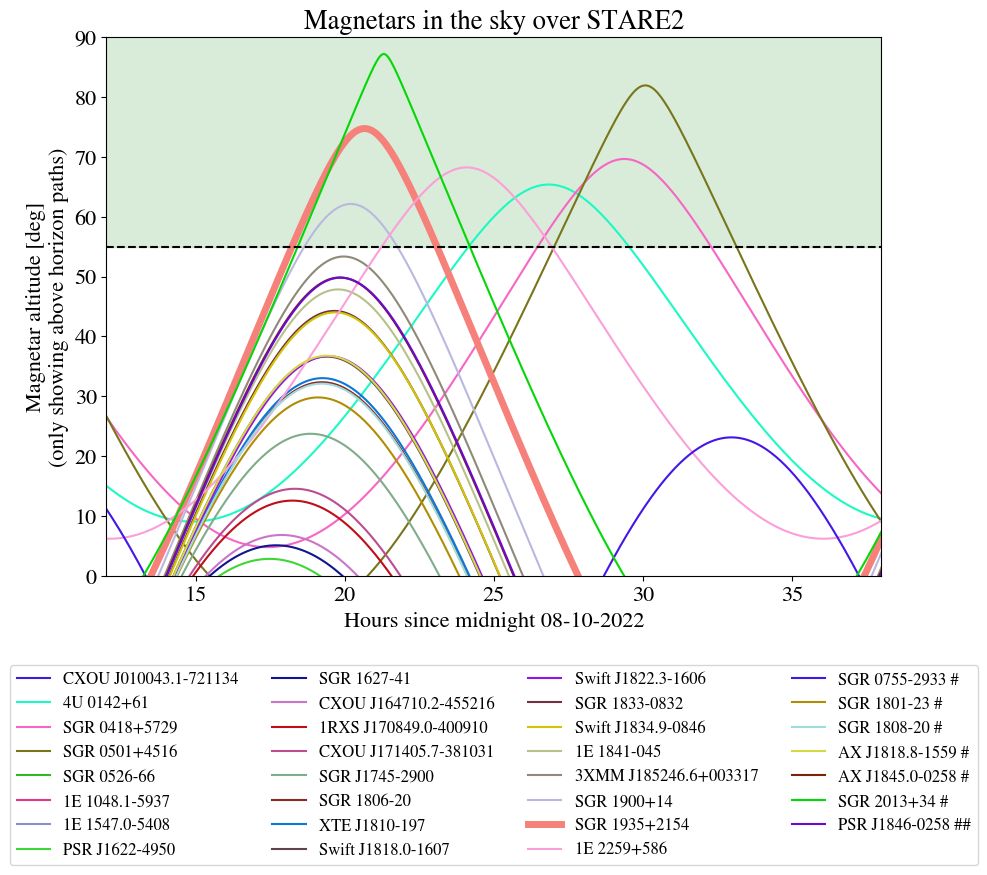

In [8]:
plt.figure(figsize=(10,7))
paths = []
for i in np.arange(0, len(mags_alts)):
    icolor=rand(3)
    path = plt.plot(hours, mags_alts[i], color=icolor, label=NAMES[i], lw=lws[i])
    paths.append(path)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=12)
plt.xlabel('Hours since midnight 08-10-2022')
plt.ylabel('Magnetar altitude [deg]\n(only showing above horizon paths)')
plt.margins(x=0, y=0.01)
plt.ylim(0, 90)
plt.title('Magnetars in the sky over STARE2')

horizon = plt.hlines(FOV, min(hours.value), max(hours.value), 'k', linestyles='dashed', label='STARE2 alt. limit', zorder=32)
range = plt.fill_between(hours.value, FOV, 95, zorder=0, alpha=0.15, color='green', label='STARE2 observable')
# paths = np.array(paths)
# legend1 = plt.legend(handles=[paths[i] for i in np.arange(len(paths))], 
#                      loc='upper center', 
#                      bbox_to_anchor=(0.5, -0.15), 
#                      ncol=4, 
#                      fontsize=12)
# plt.gca().add_artist(legend1)
# legend2 = plt.legend(handles=[horizon, range], loc='upper left', bbox_to_anchor=(1,1), fontsize=13)


plt.show();

In [9]:
mag_alts = np.array(mags_alts)
mag_alts.shape

def visible():
    results = []
    for mag in np.arange(len(mag_alts)):
        for i in mag_alts[mag]:
            if i < 55:
                results.append(0)
            elif i > 55:
                results.append(1)
    return results

In [10]:
vis = visible()
vis = np.reshape(vis, (31, 500))

In [11]:
observable_mags = []
nonobservable_mags = []
for i in np.arange(len(vis)):
    if np.any(vis[i]==1):
        observable_mags.append(i)
    elif np.all(vis[i]==0):
        nonobservable_mags.append(i)

In [12]:
print('Number of magnetars observable by STARE2:', len(observable_mags))

Number of magnetars observable by STARE2: 7


In [13]:
print('The magnetars visible to STARE2:\n', NAMES[observable_mags])

The magnetars visible to STARE2:
 1        4U 0142+61
2     SGR 0418+5729
3     SGR 0501+4516
21      SGR 1900+14
22    SGR 1935+2154
23      1E 2259+586
29    SGR 2013+34 #
Name: Name, dtype: object


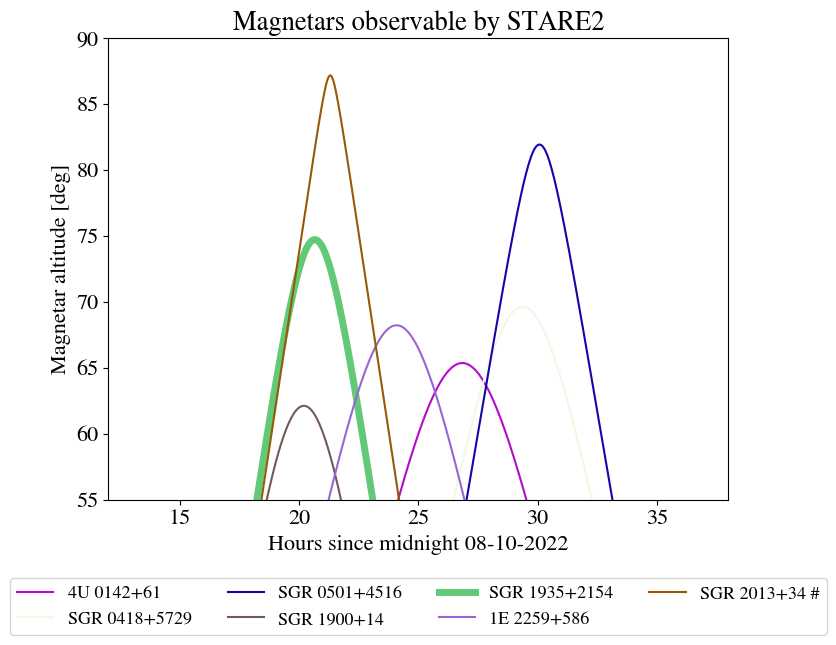

In [14]:
plt.figure(figsize=(8,6))
for i in observable_mags:
    icolor=rand(3)
    plt.plot(hours, mags_alts[i], color=icolor, label=NAMES[i], lw=lws[i])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=13)
plt.xlabel('Hours since midnight 08-10-2022')
plt.ylabel('Magnetar altitude [deg]')
plt.margins(x=0, y=0.01)
plt.ylim(FOV, 90)
plt.title('Magnetars observable by STARE2')

# horizon = plt.hlines(FOV, min(hours.value), max(hours.value), 'k', linestyles='dashed', label='STARE2 alt. limit', zorder=32)
# range = plt.fill_between(hours.value, FOV, 90, zorder=0, alpha=0.15, color='green', label='STARE2 observable')

plt.show();

In [15]:
above_FOV = []

for i in np.arange(len(observable_mags)):
    intercepts = np.array([np.argwhere(mag_alts[observable_mags[i]]>FOV)[0], np.argwhere(mag_alts[observable_mags[i]]>FOV)[-1]])
    above_FOV.append(intercepts)


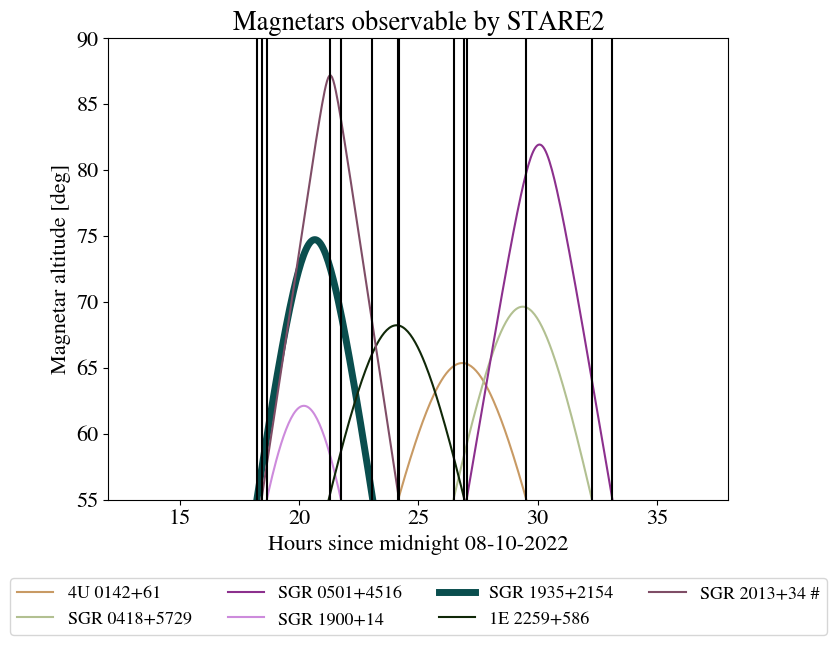

In [16]:
plt.figure(figsize=(8,6))
for i in observable_mags:
    icolor=rand(3)
    plt.plot(hours, mags_alts[i], color=icolor, label=NAMES[i], lw=lws[i])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=13)
plt.xlabel('Hours since midnight 08-10-2022')
plt.ylabel('Magnetar altitude [deg]')
plt.margins(x=0, y=0.01)
plt.ylim(FOV, 90)
plt.title('Magnetars observable by STARE2')
for i in np.arange(len(above_FOV)):
    plt.vlines(hours[above_FOV[i]].value, FOV, 90, 'k')
# plt.vlines(hours[above_FOV[0][0][0]].value, FOV, 90, 'k')
# plt.vlines(hours[above_FOV[1]].value, FOV, 90, 'k')

plt.show();

In [17]:
observable_time = []

for i in np.arange(len(observable_mags)):
    time = np.abs(np.subtract(*hours[above_FOV[i]].value))
    observable_time.append(time)
observable_time # hours/day

[array([5.31462926]),
 array([5.78356713]),
 array([6.04408818]),
 array([3.0741483]),
 array([4.79358717]),
 array([5.62725451]),
 array([5.67935872])]

## Poisson analysis

### STARE2

In [18]:
def λ(r, t):
    return r*t

R_STARE2 = 4.19 # yr^-1 --- MJy ms fluence FRB rate from SGR1935 (computed in 'rates_vs_fluence_estimates.ipynb')
t_obs = 2090.667 # hrs -- total obs. time (computed in 'rates_vs_fluence_estimates.ipynb')
T_STARE2 = (t_obs/(24))*np.sum(observable_time) # hrs
print(T_STARE2)

λ_STARE2 = λ(R_STARE2, T_STARE2)/8760 # divide by hrs/yr
λ_STARE2 # unitless

3163.582780060121


1.5131748685447384

In [20]:
from scipy.stats import poisson

ks_STARE2 = np.arange(0, 11)
dist_STARE2 = poisson.pmf(ks_STARE2, mu=λ_STARE2)

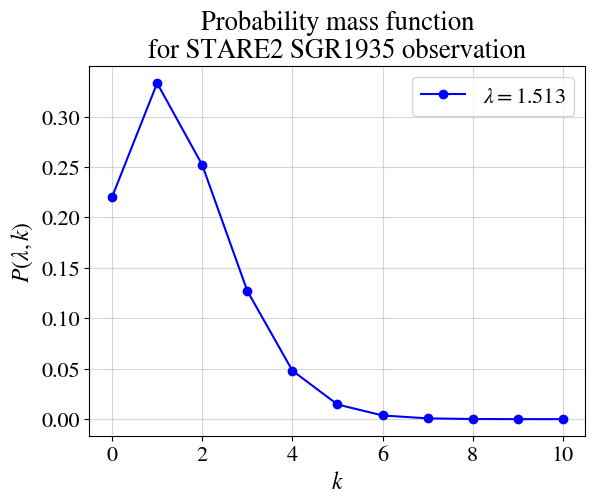

In [23]:
plt.figure()
plt.plot(ks_STARE2, dist_STARE2, 'bo-', label='$λ = {0:.3f}$'.format(λ_STARE2))
plt.title('Probability mass function\nfor STARE2 SGR1935 observation')
plt.ylabel('$P(λ, k)$', fontsize=17)
plt.xlabel('$k$', fontsize=17)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

### Kirsten et al.

In [24]:
T_euro = 522.7 # hrs
R_euro = 33.5 # yr^-1 --- Jy ms rate from SGR1935 (computed in 'rates_vs_fluence_estimates.ipynb')

λ_euro = λ(R_euro, T_euro)/8760 # divide by hrs/yr
λ_euro # unitless

1.9989098173515982

In [25]:
ks_euro = np.arange(0, 11)
dist_euro = poisson.pmf(ks_euro, mu=λ_euro)

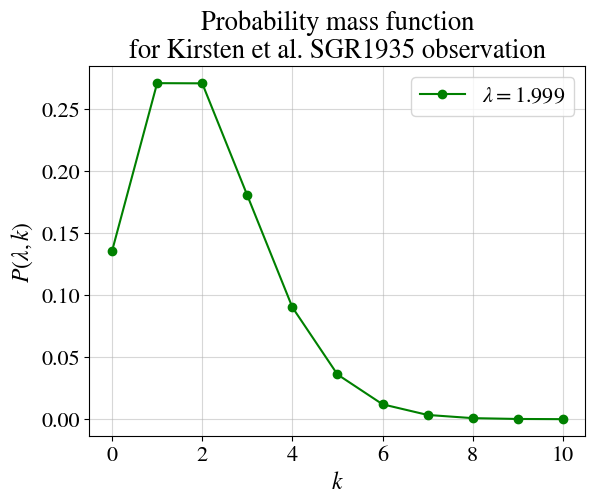

In [26]:
plt.figure()
plt.plot(ks_euro, dist_euro, 'go-', label='$λ = {0:.3f}$'.format(λ_euro))
plt.title('Probability mass function\nfor Kirsten et al. SGR1935 observation')
plt.ylabel('$P(λ, k)$', fontsize=17)
plt.xlabel('$k$', fontsize=17)
plt.legend()
plt.grid(alpha=0.5)

<Figure size 640x480 with 0 Axes>

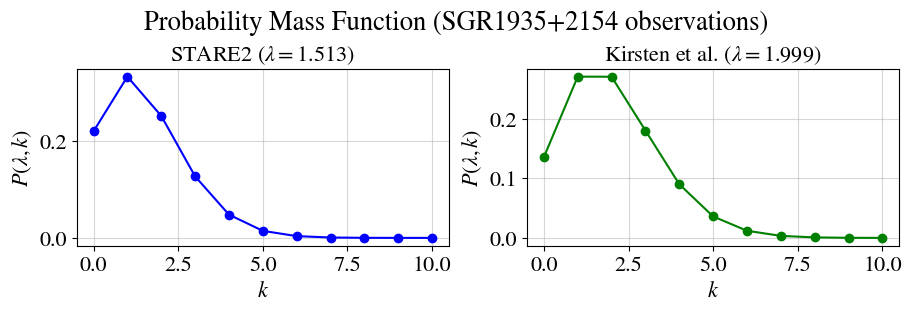

In [34]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,3), constrained_layout=True)
ax0.plot(ks_STARE2, dist_STARE2, 'bo-')
ax1.plot(ks_euro, dist_euro, 'go-')
ax0.set_ylabel('$P(λ, k)$', fontsize=16)
ax1.set_ylabel('$P(λ, k)$', fontsize=16)
ax0.set_xlabel('$k$', fontsize=16)
ax1.set_xlabel('$k$', fontsize=16)
ax0.grid(alpha=0.5), ax1.grid(alpha=0.5)
plt.suptitle('Probability Mass Function (SGR1935+2154 observations)')

ax0.set_title('STARE2 ($λ = {0:.3f}$)'.format(λ_STARE2), fontsize=16)
ax1.set_title('Kirsten et al. ($λ = {0:.3f}$)'.format(λ_euro), fontsize=16)

plt.show()

In [35]:
σ_STARE2 = np.sqrt(λ_STARE2)
σ_euro = np.sqrt(λ_euro)

print('STARE2 STD:', σ_STARE2, '\nKirsten et al. STD:', σ_euro)

STARE2 STD: 1.230111730106147 
Kirsten et al. STD: 1.4138280720623702


<Figure size 640x480 with 0 Axes>

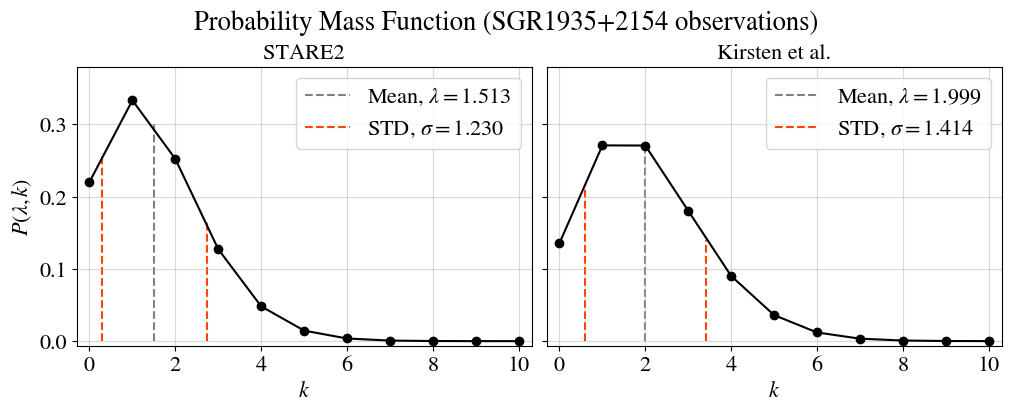

In [36]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True, sharey=True)
ax0.plot(ks_STARE2, dist_STARE2, 'ko-')
ax1.plot(ks_euro, dist_euro, 'ko-')
ax0.set_ylabel('$P(λ, k)$', fontsize=16)
# ax1.set_ylabel('$P(λ, k)$', fontsize=16)
ax0.set_xlabel('$k$', fontsize=16)
ax1.set_xlabel('$k$', fontsize=16)
ax0.grid(alpha=0.5), ax1.grid(alpha=0.5)
plt.suptitle('Probability Mass Function (SGR1935+2154 observations)')

ax0.set_title('STARE2', fontsize=16)
ax1.set_title('Kirsten et al.', fontsize=16)

ax0.vlines(λ_STARE2, 0, 0.30, 'grey', linestyles='dashed', label='Mean, $λ={0:.3f}$'.format(λ_STARE2), zorder=1)
ax0.vlines(λ_STARE2-σ_STARE2, 0, 0.26, 'orangered', linestyles='dashed', label='STD, $σ={0:.3f}$'.format(σ_STARE2), zorder=1)
ax0.vlines(λ_STARE2+σ_STARE2, 0, 0.165, 'orangered', linestyles='dashed', zorder=1)
ax0.legend()

ax1.vlines(λ_euro, 0, 0.27, 'grey', linestyles='dashed', label='Mean, $λ={0:.3f}$'.format(λ_euro), zorder=1)
ax1.vlines(λ_euro-σ_euro, 0, 0.218, 'orangered', linestyles='dashed', label='STD, $σ={0:.3f}$'.format(σ_euro), zorder=1)
ax1.vlines(λ_euro+σ_euro, 0, 0.14, 'orangered', linestyles='dashed', zorder=1)
ax1.legend()

ax0.margins(y=0.02, x=0.03)
ax1.margins(y=0.02, x=0.03)

ax0.set_ylim(top=0.38)
# ax1.set_ylim(top=0.40)
plt.show()

### Make a function of rate (R)

In [37]:
R_range_STARE2 = np.linspace(0, 25, 1000)
R_range_euro = np.linspace(0, 200, 1000)

T_STARE2_yrs = T_STARE2/8760
T_euro_yrs = T_euro/8760

print(T_STARE2_yrs, T_euro_yrs)

0.36113958676485397 0.0596689497716895


Normalization constants A were determined by solving the following integral for each observation (STARE2 and Kirsten et al.):
$1 = \int_0^\infty A P(R)dR$

Furthermore, the median was manually solved for by solving the following integral:
$\frac{1}{2} = \int_{R_{med}}^\infty A P(R)dR$

In [38]:
# Normalization constants -- UNITLESS
A_STARE2 = T_STARE2_yrs
A_euro = T_euro_yrs 

# Median values
R_median_STARE2 = 4.641
R_median_euro = 44.815

k_STARE2 = 1
k_euro = 2

In [90]:
def P(A, R, T, k):
    a = (R*T)**k
    b = np.exp(-R*T)
    c = factorial(k)
    return A*(a*b)/c

prob_dist_STARE2 = P(A_STARE2, R_range_STARE2, T_STARE2_yrs, k_STARE2)
prob_dist_euro = P(A_euro, R_range_euro, T_euro_yrs, k_euro)

The standard deviation ($1\sigma$) is computed by integrating to 16% and 84% for the lower and upper bounds.

$0.16 = \int_{R_{med}}^\infty A P(R)dR$

$0.84 = \int_{R_{med}}^\infty A P(R)dR$

Once again, these integrals are solved numerically.

In [91]:
# 1σ  R values
minus_std_STARE2 = 1.969
plus_std_STARE2 = 9.093

minus_std_euro = 23.009
plus_std_euro = 77.511


# 1σ values
plus_1σ_STARE2 = plus_std_STARE2 - R_median_STARE2 
minus_1σ_STARE2 = R_median_STARE2 - minus_std_STARE2

plus_1σ_euro = plus_std_euro - R_median_euro
minus_1σ_euro = R_median_euro - minus_std_euro

<Figure size 640x480 with 0 Axes>

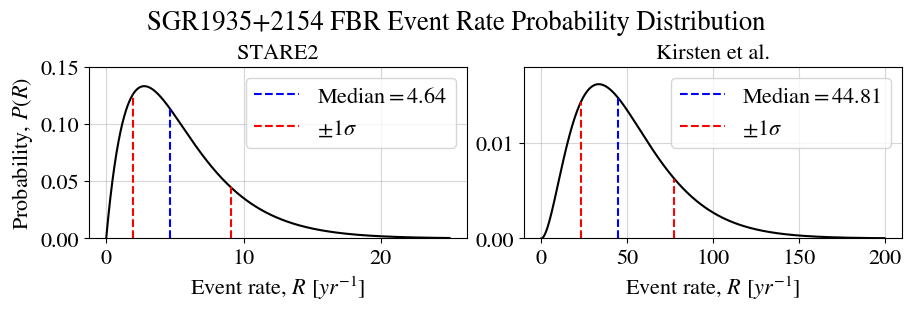

In [92]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,3), constrained_layout=True, sharey=False)
ax0.plot(R_range_STARE2, prob_dist_STARE2, 'k-')
ax1.plot(R_range_euro, prob_dist_euro, 'k-')

ax0.set_ylabel('Probability, $P(R)$', fontsize=16)

ax0.set_xlabel('Event rate, $R$ $[yr^{-1}]$', fontsize=16)
ax1.set_xlabel('Event rate, $R$ $[yr^{-1}]$', fontsize=16)

ax0.grid(alpha=0.5), ax1.grid(alpha=0.5)
plt.suptitle('SGR1935+2154 FBR Event Rate Probability Distribution')

ax0.set_title('STARE2', fontsize=16)
ax1.set_title('Kirsten et al.', fontsize=16)

ax0.vlines(R_median_STARE2, 0, P(A_STARE2, R_median_STARE2, T_STARE2_yrs, k_STARE2), color='blue', linestyles='dashed', zorder=3, label='Median$ = {0:.2f}$'.format(R_median_STARE2))
ax0.vlines(plus_std_STARE2, 0, P(A_STARE2, plus_std_STARE2, T_STARE2_yrs, k_STARE2), color='red', linestyles='dashed', zorder=3, label='$\pm1σ$')
ax0.vlines(minus_std_STARE2, 0, P(A_STARE2, minus_std_STARE2, T_STARE2_yrs, k_STARE2), color='red', linestyles='dashed', zorder=3)

ax1.vlines(R_median_euro, 0, P(A_euro, R_median_euro, T_euro_yrs, k_euro), color='blue', linestyles='dashed', zorder=3, label='Median$ = {0:.2f}$'.format(R_median_euro))
ax1.vlines(plus_std_euro, 0, P(A_euro, plus_std_euro, T_euro_yrs, k_euro), color='red', linestyles='dashed', zorder=3, label='$\pm1σ$')
ax1.vlines(minus_std_euro, 0, P(A_euro, minus_std_euro, T_euro_yrs, k_euro), color='red', linestyles='dashed', zorder=3)

ax0.legend()
ax1.legend()

ax0.margins(y=0)
ax0.set_ylim(top=0.15)
ax1.margins(y=0)
ax1.set_ylim(top=0.018)

plt.show()

## Rate vs. Fluences

### With the look-elsewhere effect:

In [93]:
obs_rate_LEE = np.log10([R_median_euro, R_median_STARE2])
obs_fluence_pnts = np.log10([24, 1.5e6]) # Take the lower burst from Kirsten et al.
rate_err = np.array([np.log10([R_median_euro+plus_1σ_euro, R_median_euro-minus_1σ_euro]), 
                     np.log10([R_median_STARE2+plus_1σ_STARE2, R_median_STARE2-minus_1σ_STARE2])])
pm_err = [np.abs(obs_rate_LEE[i]-rate_err[i]) for i in np.arange(2)]
np.array(pm_err).T

array([[0.23793994, 0.29209562],
       [0.28952566, 0.37236585]])

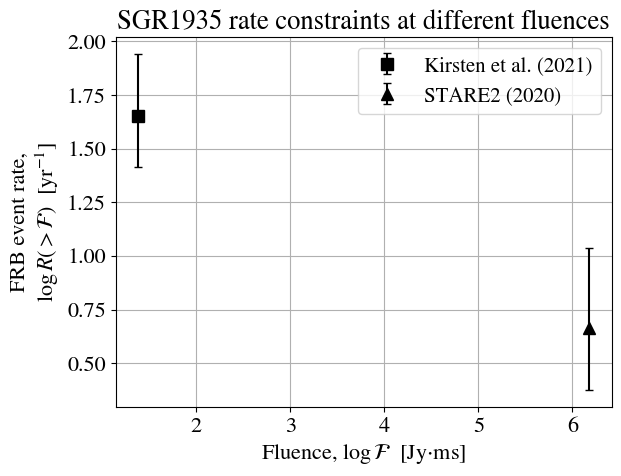

In [143]:
plt.figure()

plt.title('SGR1935 rate constraints at different fluences')

obs_labels = ['Kirsten et al. (2021)', 'STARE2 (2020)']
obs_markers = ['s', '^']
for i in np.arange(2):
    plt.errorbar(obs_fluence_pnts[i], obs_rate_LEE[i], yerr=np.array([pm_err[i]]).T, color='k', capsize=3,
                 marker=obs_markers[i], label=obs_labels[i], markersize=8, linestyle='None')

plt.xlabel('Fluence, $\mathcal{\log{F}}$  [Jy$\cdot$ms]')
plt.ylabel('FRB event rate,\n$\log{R(>\mathcal{F}}$)  [yr$^{-1}$]')

plt.legend(loc='upper right', fontsize=15)
plt.grid()

plt.show()

## MCMC

Reference: https://emcee.readthedocs.io/en/stable/tutorials/line/

In [66]:
### [EURO, STARE2]
R_meds = np.log10([R_median_euro, R_median_STARE2])
F_meds = np.log10([24, 1.5e6])

ks = np.array([float(k_euro), float(k_STARE2)])
As = np.array([A_euro, A_STARE2])
Ts = np.array([T_euro_yrs, T_STARE2_yrs])

In [98]:
def log_likelihood(pars, F, A, T, k):
    # XXX log(P) = log(P1(R1) * P2(R2))
    # P_i given by black curves above
    m, b = pars
    R1 = F[0]*m + b
    R2 = F[1]*m + b
    P1 = P(A[0], 10**R1, T[0], k[0])
    P2 = P(A[1], 10**R2, T[1], k[1])
    logP = np.log10(P1*P2)
    return logP

In [99]:
nll = lambda *args: -log_likelihood(*args) 
# maximizing the likelihood is the same as minimizing the negative of the liklihood

initial = np.array([-0.25, 2])
soln = minimize(nll, initial, args=(F_meds, As, Ts, ks))
m_ml, b_ml = soln.x # maximum likelihood values

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))

Maximum likelihood estimates:
m = -0.226
b = 1.837


/tmp/ipykernel_129/378920184.py:4: DeprecationWarning: Using factorial() with floats is deprecated
  c = factorial(k)


In [100]:
def log_prior(pars): # sets up priors on theta
    m, b = pars
    if -2 < m < 1 and -1 < b < 8:
        return 0.0
    return -np.inf

In [103]:
def log_probability(pars, F, A, T, k):
    lp = log_prior(pars) 
    if not np.isfinite(lp): 
        return -np.inf
    if np.isnan(lp + log_likelihood(pars, F, A, T, k)):
        return -np.inf
    return lp + log_likelihood(pars, F, A, T, k)

In [121]:
pos = soln.x + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

nsamp = int(100e3)

sampler = emcee.EnsembleSampler(nwalkers,
                                ndim, 
                                log_probability, 
                                args=(F_meds, As, Ts, ks))

sampler.run_mcmc(pos, nsamp, progress=True);

/tmp/ipykernel_129/378920184.py:4: DeprecationWarning: Using factorial() with floats is deprecated
  c = factorial(k)
  0%|                                      | 0/100000 [00:00<?, ?it/s]/tmp/ipykernel_129/3196900100.py:9: RuntimeWarning: divide by zero encountered in log10
  logP = np.log10(P1*P2)
100%|████████████████████████| 100000/100000 [04:22<00:00, 381.04it/s]


In [122]:
samples = sampler.get_chain()

tau = sampler.get_autocorr_time()
print('Integrated autocorrelation time:', tau)

Integrated autocorrelation time: [38.9031265  36.21200608]


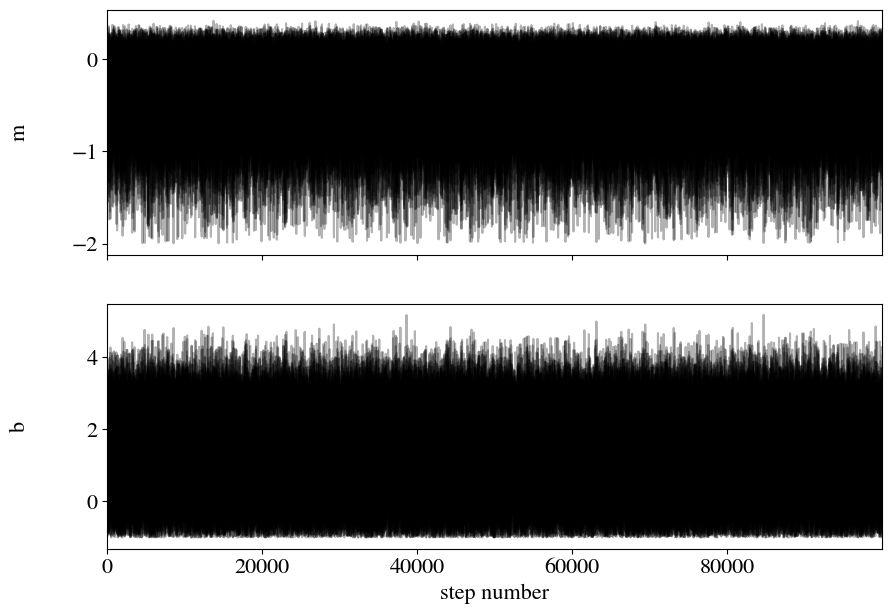

In [123]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
labels = ['m', 'b']
for i in np.arange(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples)-1)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel('step number');

In [133]:
flat_samples = sampler.get_chain(discard=120, thin=20, flat=True)
print(flat_samples.shape)

(159808, 2)


In [134]:
ms, bs = flat_samples[:, 0], flat_samples[:, 1]

In [261]:
bins = 165

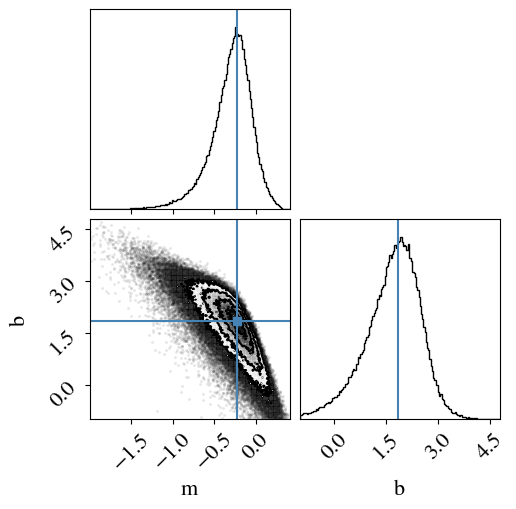

In [262]:
fig = corner.corner(flat_samples, labels=labels, truths=soln.x, bins=bins)

In [263]:
hist_ms = np.histogram(ms, bins=bins, density=True)
hist_bs = np.histogram(bs, bins=bins, density=True)

max_ms_ind = np.argmax(hist_ms[0])
max_bs_ind = np.argmax(hist_bs[0])

max_post_m = hist_ms[1][max_ms_ind]
max_post_b = hist_bs[1][max_bs_ind]

print('Max posterior values:\nm = {0:.3f}\nb = {1:.3f}'.format(max_post_m, max_post_b))

Max posterior values:
m = -0.248
b = 1.912


<Figure size 640x480 with 0 Axes>

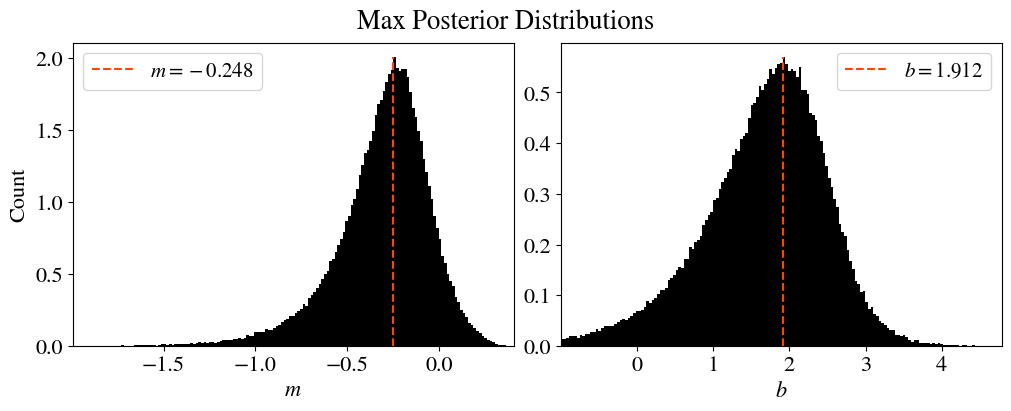

In [264]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True, sharey=False)

ax0.hist(ms, bins=bins, color='k', alpha=1, density=True)
ax1.hist(bs, bins=bins, color='k', alpha=1, density=True)
plt.suptitle('Max Posterior Distributions')
ax0.set_ylabel('Count')
ax0.set_xlabel('$m$')
ax1.set_xlabel('$b$')

ax0.vlines(max_post_m, 0, np.max(hist_ms[0]), color='orangered', linestyles='--', label='$m = {0:.3f}$'.format(max_post_m))
ax1.vlines(max_post_b, 0, np.max(hist_bs[0]), color='orangered', linestyles='--', label='$b = {0:.3f}$'.format(max_post_b))
ax0.legend(fontsize=15)
ax1.legend(fontsize=15)
ax0.margins(x=0)
ax1.margins(x=0)
plt.show()

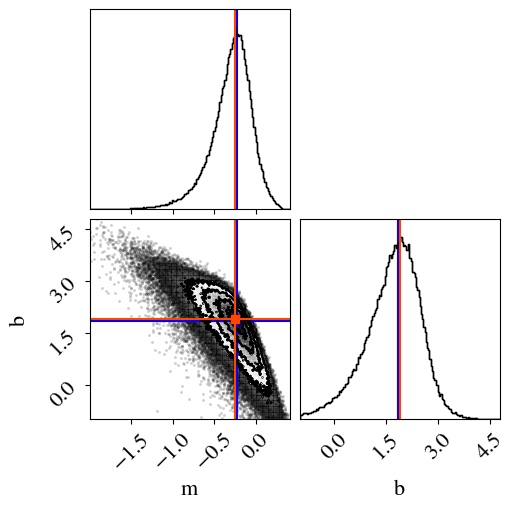

In [265]:
fig = corner.corner(flat_samples, labels=labels, truths=soln.x, truth_color='blue', bins=bins,)
corner.corner(flat_samples, alpha=0, truths=[max_post_m, max_post_b], truth_color='orangered', fig=fig, bins=bins);

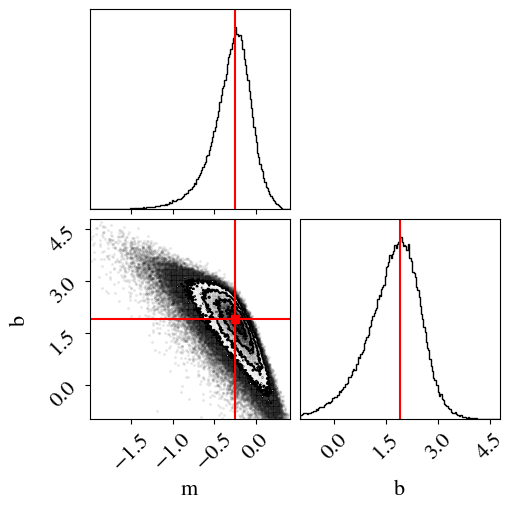

In [266]:
fig = corner.corner(flat_samples, 
                    alpha=0, 
                    truths=[max_post_m, max_post_b], 
                    truth_color='red', 
                    bins=bins,
                    labels=labels);

In [267]:
### quick least squares ###
def ls_model(x, m, b):
    y=m*x+b
    return y

guesses = np.array([-0.2, 2])
pop, cov = scipy.optimize.curve_fit(ls_model, F_meds, R_meds, guesses, absolute_sigma=True)
m_ls, b_ls = pop
print(pop)

[-0.20534539  1.93484341]


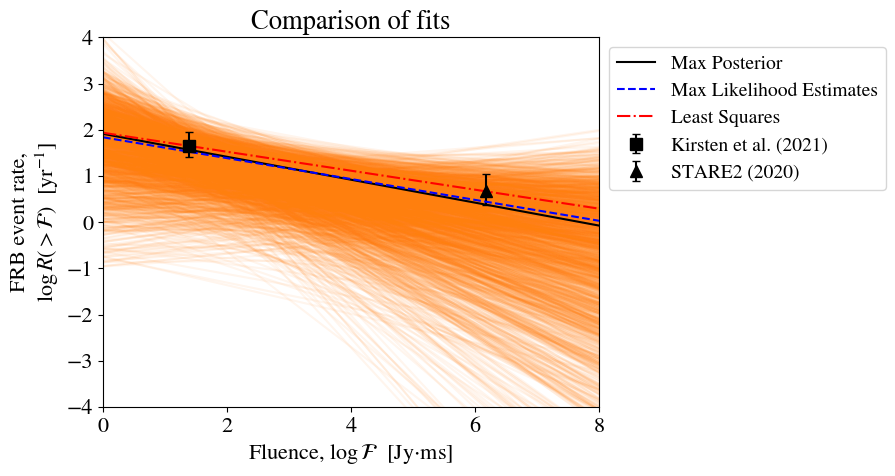

In [268]:
x0 = np.linspace(0, 10, 500)

fig, ax = plt.subplots()
ax.set_title('Comparison of fits')
inds = np.random.randint(len(flat_samples), size=2000)
for ind in inds:
    sample = flat_samples[ind]
    ax.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), color='C1', alpha=0.075)
obs_labels = ['Kirsten et al. (2021)', 'STARE2 (2020)']
obs_markers = ['s', '^']
for i in np.arange(2):
    ax.errorbar(F_meds[i], R_meds[i], yerr=np.array([pm_err[i]]).T, color='k', capsize=3,
                 marker=obs_markers[i], label=obs_labels[i], markersize=8, linestyle='None')

ys_mp = max_post_m*x0 + max_post_b
ys_ml = m_ml*x0 + b_ml
ys_ls = m_ls*x0 + b_ls
ax.plot(x0, ys_mp, 'k', linestyle='-', label='Max Posterior')
ax.plot(x0, ys_ml, 'b', linestyle='--', label='Max Likelihood Estimates')
ax.plot(x0, ys_ls, 'r', linestyle='-.', label='Least Squares')

ax.legend(fontsize=14, bbox_to_anchor=(1,1), loc='upper left')
ax.set_xlim(0, 8)
ax.set_ylim(-4, 4)
ax.set_xlabel('Fluence, $\mathcal{\log{F}}$  [Jy$\cdot$ms]')
ax.set_ylabel('FRB event rate,\n$\log{R(>\mathcal{F}}$)  [yr$^{-1}$]')
plt.show()

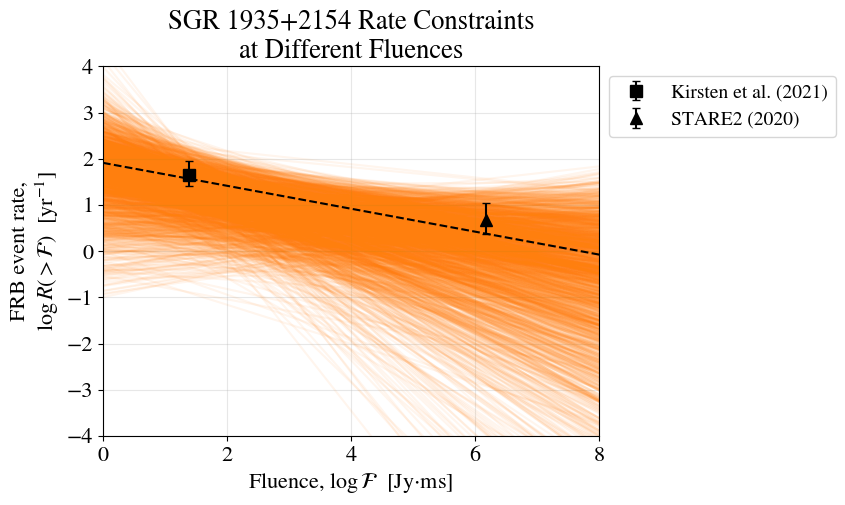

In [269]:
fig, ax = plt.subplots()
ax.set_title('SGR 1935+2154 Rate Constraints\nat Different Fluences')
inds = np.random.randint(len(flat_samples), size=2000)
for ind in inds:
    sample = flat_samples[ind]
    ax.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), color='C1', alpha=0.075)
obs_labels = ['Kirsten et al. (2021)', 'STARE2 (2020)']
obs_markers = ['s', '^']
for i in np.arange(2):
    ax.errorbar(F_meds[i], R_meds[i], yerr=np.array([pm_err[i]]).T, color='k', capsize=3,
                 marker=obs_markers[i], label=obs_labels[i], markersize=8, linestyle='None')

ax.plot(x0, ys_mp, 'k', linestyle='--')

ax.legend(fontsize=14, bbox_to_anchor=(1,1), loc='upper left')
ax.set_xlim(0, 8)
ax.set_ylim(-4, 4)
ax.set_xlabel('Fluence, $\mathcal{\log{F}}$  [Jy$\cdot$ms]')
ax.set_ylabel('FRB event rate,\n$\log{R(>\mathcal{F}}$)  [yr$^{-1}$]')
ax.grid(alpha=0.3)
plt.show()

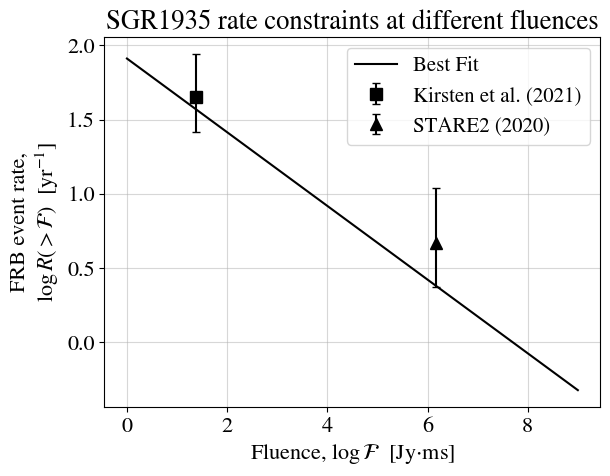

In [270]:
plt.figure()

plt.title('SGR1935 rate constraints at different fluences')

obs_labels = ['Kirsten et al. (2021)', 'STARE2 (2020)']
obs_markers = ['s', '^']
for i in np.arange(2):
    plt.errorbar(F_meds[i], R_meds[i], yerr=np.array([pm_err[i]]).T, color='k', capsize=3,
                 marker=obs_markers[i], label=obs_labels[i], markersize=8, linestyle='None')

plt.xlabel('Fluence, $\mathcal{\log{F}}$  [Jy$\cdot$ms]')
plt.ylabel('FRB event rate,\n$\log{R(>\mathcal{F}}$)  [yr$^{-1}$]')

xs = np.linspace(0,9)
ys_mp = max_post_m*xs + max_post_b

plt.plot(xs, ys_mp, 'k-', label='Best Fit')

plt.legend(loc='upper right', fontsize=15)
plt.grid(alpha=0.5)

plt.show()